In [4]:
import warnings
warnings.filterwarnings("ignore")

### LIBRARIES

In [5]:
# General imports
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statistics

# Data splitting and model evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

# Performance metrics
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

# Model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Imbalanced dataset handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline


### MODEL DEVELOPMENT

### Can perceived health be accurately predicted using dietary habits, socioeconomic indicators, lifestyle choices, and individual metrics?

In [6]:
%matplotlib inline

In [7]:
#Read in cleaned 2019 and 2021 Dataframes with numerical outliers removed
model_train = pd.read_csv('mydata/MMSA2019_Cleaned_2.csv')
model_valid = pd.read_csv('mydata/MMSA2021_Cleaned_2.csv')

In [8]:
model_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83666 entries, 0 to 83665
Data columns (total 97 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DISPCODE  83666 non-null  int64  
 1   HHADULT   83666 non-null  float64
 2   SEXVAR    83666 non-null  object 
 3   GENHLTH   83666 non-null  object 
 4   PHYSHLTH  83666 non-null  float64
 5   MENTHLTH  83666 non-null  float64
 6   _HLTHPLN  83666 non-null  object 
 7   MEDCOST1  83666 non-null  object 
 8   CHECKUP1  83666 non-null  object 
 9   CVDINFR4  83666 non-null  object 
 10  CVDCRHD4  83666 non-null  object 
 11  CVDSTRK3  83666 non-null  object 
 12  ASTHMA3   83666 non-null  object 
 13  CHCSCNCR  83666 non-null  object 
 14  CHCOCNCR  83666 non-null  object 
 15  ADDEPEV3  83666 non-null  object 
 16  CHCKDNY2  83666 non-null  object 
 17  DIABETE4  83666 non-null  object 
 18  MARITAL   83666 non-null  object 
 19  EDUCA     83666 non-null  object 
 20  RENTHOM1  83666 non-null  ob

In [9]:
model_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104619 entries, 0 to 104618
Data columns (total 97 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DISPCODE  104619 non-null  int64  
 1   HHADULT   104619 non-null  float64
 2   SEXVAR    104619 non-null  object 
 3   GENHLTH   104619 non-null  object 
 4   PHYSHLTH  104619 non-null  float64
 5   MENTHLTH  104619 non-null  float64
 6   _HLTHPLN  104619 non-null  object 
 7   MEDCOST1  104619 non-null  object 
 8   CHECKUP1  104619 non-null  object 
 9   CVDINFR4  104619 non-null  object 
 10  CVDCRHD4  104619 non-null  object 
 11  CVDSTRK3  104619 non-null  object 
 12  ASTHMA3   104619 non-null  object 
 13  CHCSCNCR  104619 non-null  object 
 14  CHCOCNCR  104619 non-null  object 
 15  ADDEPEV3  104619 non-null  object 
 16  CHCKDNY2  104619 non-null  object 
 17  DIABETE4  104619 non-null  object 
 18  MARITAL   104619 non-null  object 
 19  EDUCA     104619 non-null  object 
 20  RENT

<Axes: xlabel='_RFHLTH', ylabel='count'>

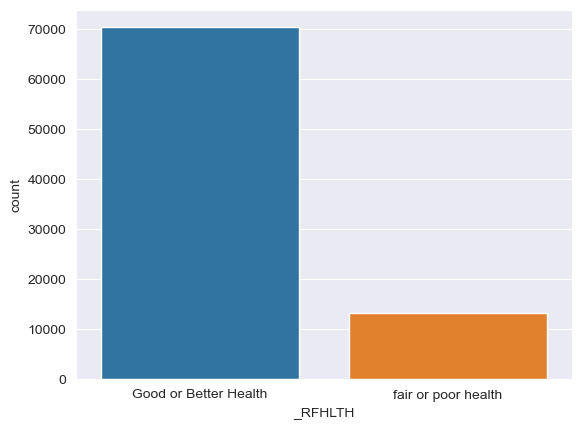

In [10]:
#Balance of the Dataset (TARGET VARIABLE _RFHLTH)
sns.set_style('darkgrid')
sns.countplot(x=model_train['_RFHLTH'])

### Link to Data dictionary
[Data Dictionary](https://github.com/OBINNADINNEYA/MY_BIGDATA_PROJECT/tree/branch_1/Questionnaires%20and%20Calculated%20variables%20(Data%20Dictionary))

We can see that the ratio of those who percieve their health to be good vs those who do not is 7:1 an indication of a highly imbalanced Dataset. We can apply SMOTE technique to introduced randomn samples of the lower class in order to balance out the samples for model training.

In [40]:
# Creating a new data frame with only dummmy categorical data and num columns 
num_cols = list(model_train.select_dtypes(exclude='object').columns)
cat_cols = list(model_train.select_dtypes(include='object').columns)

dummies_df = model_train[num_cols]
cat_cols = list(cat_cols)

for i in ['GENHLTH','_RFHLTH']:
    cat_cols.remove(i)


for i in cat_cols:
    temp = pd.get_dummies(model_train[i], drop_first=True, prefix=i)
    dummies_df = pd.concat([dummies_df, temp.astype(int)], axis=1)

dummies_df.head()

,DISPCODE,HHADULT,PHYSHLTH,MENTHLTH,CPDEMO1B,CHILDREN,WEIGHT2,HEIGHT3,_STSTR,_PHYS14D,...,STATE_South Carolina,STATE_South Dakota,STATE_Tennessee,STATE_Texas,STATE_Utah,STATE_Vermont,STATE_Virginia,STATE_Washington,STATE_West Virginia,STATE_Wisconsin
0,1200,2.0,0.0,0.0,2.0,3.0,180.0,1.7780,16049,1,...,0,1,0,0,0,0,0,0,0,0
1,1200,3.0,20.0,0.0,1.0,0.0,265.0,1.8034,16049,3,...,0,1,0,0,0,0,0,0,0,0
2,1200,1.0,1.0,0.0,1.0,0.0,170.0,1.7272,16049,2,...,0,1,0,0,0,0,0,0,0,0
3,1100,2.0,0.0,0.0,1.0,4.0,280.0,1.8288,16039,1,...,0,1,0,0,0,0,0,0,0,0
4,1100,2.0,0.0,0.0,1.0,0.0,270.0,1.9304,16049,1,...,0,1,0,0,0,0,0,0,0,0


In [41]:
dummies_df.columns = dummies_df.columns.astype(str)
model_train.columns = model_train.columns.astype(str)

In [22]:
#2019 dataset
X = dummies_df
y = model_train['_RFHLTH']

## BASE MODELS

### Base Decision Tree Model

- **Grid Search:** Utilized to fine-tune model hyperparameters ensuring optimal complexity and preventing overfitting.
- **SMOTE Application:** SMOTE is applied exclusively to the training set to address class imbalance, creating synthetic samples to present the model with a balanced class representation during training.
- **Stratified K-Fold Cross-Validation:** Ensures each fold has a representative ratio of the target classes, improving model evaluation and maintaining robustness against class imbalance.

> **Note:** Stratified K-Fold is critical for imbalanced datasets to ensure that performance metrics reflect a model's true predictive power without bias introduced by uneven class distribution across folds.



In [11]:
#1) Base Decision Tree Model

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#SMOTE was included in the pipeline as it has been shown to produce accuracy closer to that in the test accuracy result
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid:
#limiting the max_depth of the tree to prevent overfitting
param_grid = {
    'classifier__max_depth': [None,10, 20],  
    'classifier__min_samples_split': [2, 10], 
    'classifier__min_samples_leaf': [1, 5]  
}

# Cross-validation setup
# Speak to the hyperparameters
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

# GridSearch setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=stratified_kfold,
    n_jobs=-1
)

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Making predictions on the test set
predictions = grid_search.predict(X_test)

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best score: 0.8744696522985347

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.92      0.93      0.93     14038
  fair or poor health       0.62      0.57      0.59      2696

             accuracy                           0.87     16734
            macro avg       0.77      0.75      0.76     16734
         weighted avg       0.87      0.87      0.87     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[13085   953]
 [ 1163  1533]]


In [12]:
#2) Base Logistic Regression with SMOTE and  Gridsearch

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Creating a logistic regression model instance
logreg_model = LogisticRegression(max_iter=1000)

# Creating a pipeline with SMOTE and Logistic Regression
pipeline = IMBPipeline([
    ('smote', SMOTE()),
    ('logreg', logreg_model)
])

# Defining the parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1],
    'logreg__solver': ['lbfgs']
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_

# Predictions and evaluation using the best estimator
y_pred = best_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}
Classification Report:
                        precision    recall  f1-score   support

Good or Better Health       0.95      0.84      0.90     14038
  fair or poor health       0.49      0.78      0.60      2696

             accuracy                           0.83     16734
            macro avg       0.72      0.81      0.75     16734
         weighted avg       0.88      0.83      0.85     16734



In [13]:
#3) Base Randomn forest Model

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Pipeline with SMOTE and Random Forest classifier
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf_classifier)
])

# Parameter grid for Random Forest classifier including the default parameters, to get the best parameters 
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# StratifiedKFold to maintain the class distribution within each fold for accurate representation of dataset
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1  
)

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Making predictions on the test set
predictions = grid_search.predict(X_test)

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best score: 0.8897985931591725

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.92      0.94      0.93     14038
  fair or poor health       0.67      0.58      0.62      2696

             accuracy                           0.89     16734
            macro avg       0.79      0.76      0.78     16734
         weighted avg       0.88      0.89      0.88     16734

Confusion Matrix (Test Data):
 [[13263   775]
 [ 1134  1562]]


## FEATURE SELECTED MODELS

We will be using the built in feature selector from the randomn forrest:
    
For our transformation, I've chosen the MinMaxScaler for numeric features and the OrdinalEncoder encoder for categorical features. In the final model, I would most likely OneHotEncode (OHE) for the categorical features, but to determine feature importance, we don't want to expand the columns with OHE; we'll get more value out of treating them as one column with ordinal encoded values.

In [11]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

In [50]:
# Your 2019 dataset
X = model_train.drop(columns=['_RFHLTH','GENHLTH'])
y = model_train['_RFHLTH']

In [51]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

In [52]:
# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

In [53]:
# Split the data into 20% test and 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2ace5c250>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x280c4a890>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [54]:
feat_list = []

targets = list(X.columns)

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    if feature[1] > .01:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp


 Cumulative Importance = 0.9999999999999996


,FEATURE,IMPORTANCE,CUMSUM
2,SEXVAR,0.121186,0.121186
9,CVDCRHD4,0.064373,0.185560
58,_AGE_G,0.050969,0.236529
13,CHCOCNCR,0.028213,0.264741
87,_VEG23A,0.026697,0.291439
...,...,...,...
22,EMPLOY1,0.000587,0.998764
32,SMOKE100,0.000546,0.999311
24,WEIGHT2,0.000535,0.999845
31,DIFFALON,0.000094,0.999940


In [55]:
print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))

Most Important Features:
['SEXVAR', 'PHYSHLTH', 'MEDCOST1', 'CHECKUP1', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA', 'RENTHOM1', 'CPDEMO1B', 'VETERAN3', 'DEAF', 'BLIND', 'EXERANY2', 'FLUSHOT7', 'PNEUVAC4', '_MRACE1', '_RACE', '_SEX', '_AGE80', '_AGE_G', '_BMI5', '_EDUCAG', '_RFBING5', '_VEGRES1', '_FRT16A', '_VEG23A', '_MMSAWT', 'DROCDY3_']
Number of Included Features = 35


In [56]:
#Creating a new data frame with only dummmy categorical data and num columns 
num_cols = list(model_train[included_feats].select_dtypes(exclude='object').columns)
cat_cols = list(model_train[included_feats].select_dtypes(include='object').columns)

dummies_df2 = model_train[num_cols]
cat_cols = list(cat_cols)

for i in cat_cols:
    temp = pd.get_dummies(model_train[i], drop_first=True, prefix=i)
    dummies_df2 = pd.concat([dummies_df2, temp.astype(int)], axis=1)

dummies_df2.head()

,PHYSHLTH,CPDEMO1B,_AGE80,_BMI5,_VEGRES1,_FRT16A,_VEG23A,_MMSAWT,DROCDY3_,SEXVAR_male,...,_SEX_male,_AGE_G_25-34,_AGE_G_35-44,_AGE_G_45-54,_AGE_G_55-64,_AGE_G_65&older,_EDUCAG_College_grad,_EDUCAG_HS_diploma,_EDUCAG_none,_RFBING5_yes
0,0.0,2.0,35,25.83,1,1,1,147.703815,0.285714,1,...,1,0,1,0,0,0,0,0,0,0
1,20.0,1.0,42,36.96,1,1,1,81.705709,0.233333,1,...,1,0,1,0,0,0,1,0,0,1
2,1.0,1.0,22,25.85,1,1,1,88.929326,0.133333,1,...,1,0,0,0,0,0,1,0,0,0
3,0.0,1.0,38,37.97,1,1,1,7.414992,0.100000,1,...,1,0,1,0,0,0,1,0,0,1
4,0.0,1.0,72,32.87,1,1,1,20.331805,0.142857,1,...,1,0,0,0,0,1,1,0,0,1


In [57]:
#Obtaining the selected columns and the target column
X = dummies_df2
y = model_train['_RFHLTH']

In [58]:
#1) Decision Tree Model With Selected features

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#SMOTE was included in the pipeline as it has been shown to produce accuracy closer to that in the test accuracy result
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid:
#limiting the max_depth of the tree to prevent overfitting
param_grid = {
    'classifier__max_depth': [None,10, 20],  
    'classifier__min_samples_split': [2, 10], 
    'classifier__min_samples_leaf': [1, 5]  
}

# Cross-validation setup
# Speak to the hyperparameters
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

# GridSearch setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=stratified_kfold,
    n_jobs=-1
)

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Making predictions on the test set
predictions = grid_search.predict(X_test)

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best score: 0.8588865986524364

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.92      0.91      0.91     14038
  fair or poor health       0.55      0.57      0.56      2696

             accuracy                           0.86     16734
            macro avg       0.74      0.74      0.74     16734
         weighted avg       0.86      0.86      0.86     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[12807  1231]
 [ 1163  1533]]


In [59]:
#2) Logistic Regression with Selected features

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Creating a logistic regression model instance
logreg_model = LogisticRegression(max_iter=1000)

# Creating a pipeline with SMOTE and Logistic Regression
pipeline = IMBPipeline([
    ('smote', SMOTE()),
    ('logreg', logreg_model)
])

# Defining the parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1],
    'logreg__solver': ['lbfgs']
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_

# Predictions and evaluation using the best estimator
y_pred = best_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}
Classification Report:
                        precision    recall  f1-score   support

Good or Better Health       0.95      0.85      0.90     14038
  fair or poor health       0.49      0.76      0.60      2696

             accuracy                           0.83     16734
            macro avg       0.72      0.80      0.75     16734
         weighted avg       0.87      0.83      0.85     16734



In [60]:
#3) Randomn forrest Model with Selected features

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Pipeline with SMOTE and Random Forest classifier
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf_classifier)
])

# Parameter grid for Random Forest classifier including the default parameters, to get the best parameters 
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# StratifiedKFold to maintain the class distribution within each fold for accurate representation of dataset
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1  
)

# Fitting the model on the training data Only to avoid any data leakage
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Making predictions on the test set
predictions = grid_search.predict(X_test)

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best score: 0.879773455767028

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.91      0.95      0.93     14038
  fair or poor health       0.65      0.51      0.57      2696

             accuracy                           0.88     16734
            macro avg       0.78      0.73      0.75     16734
         weighted avg       0.87      0.88      0.87     16734

Confusion Matrix (Test Data):
 [[13288   750]
 [ 1317  1379]]


In [ ]:
# Once the best model is selected, use it to make predictions on the 2021 dataset
# Assuming X_2021 and y_2021 are your 2021 dataset
# test_score = roc_auc_score(y_2021, grid_search.predict(X_2021))
# print(f'Test score on 2021 data: {test_score}')

In [ ]:
####Results 

In [ ]:
####Conclusion

## Reducing False Negatives in Health Predictions: A Crucial Goal

**Ensuring Patient Safety**: Avoiding missed diagnoses that could lead to worsened health or preventable deaths is paramount for patient safety.

**Facilitating Early Intervention**: Accurate identification of poor health allows for timely intervention, often resulting in better health outcomes.

**Lowering Healthcare Costs**: Early detection of health issues can prevent the need for more complex and expensive treatments later on.

**Improving Public Health**: Correct health status predictions are vital for efficient public health planning and resource allocation.

**Prioritizing Healthcare Needs**: With finite resources, identifying at-risk individuals ensures that care is directed where it's most needed, such as during health crises.

**Encouraging Treatment Adherence**: Patients who understand their health risks are more likely to follow treatment plans.

**Maintaining Trust**: Accurate predictions reinforce trust in the healthcare system, crucial for public cooperation in health programs.

In short, minimizing false negatives is essential for a trustworthy, cost-effective, and proactive healthcare system that truly serves its patients.
